# Calculate Allele Frequency for HDF5, and merge into the hf5 data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import h5py
import allel

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

sys.path.insert(0, "/n/groups/reich/hringbauer/git/HAPSBURG/package/")  # hack to get local package first in path
from hapsburg.PackagesSupport.h5_python.h5_functions import merge_in_ld_map

compute-a-16-121.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 32


In [13]:
def get_af(f, min_gp=0.99):
    """Get Allele Frequency"""
    gp_max = np.max(f["calldata/GP"], axis=2)
    gp_good = (gp_max>=min_gp) # The decent genotype probabilitiies
    gp_max = 0 # Delete GP max (unnecessary now)
    
    gt1 = np.sum(f["calldata/GT"], axis=2)/2.0 # Get the genotype sum
    gp_good_c = np.sum(gp_good, axis=1)
    af = np.sum(gt1 * gp_good, axis=1) / gp_good_c
    return af

def merge_in_af(path_h5, af, col_af="AF_ALL"):
    """Merge in AF into hdf5 file. Save modified h5 in place 
    af: Array of allele frequencies to save"""
    
    ### Now create the new column in hdf5
    print("Adding map to HDF5...")
    with h5py.File(path_h5, 'a') as f0:
        group = f0["variants"]
        l = len(f0["variants/POS"]) # Get number of markers
        print(f"Loaded {len(af)} variants.")
        assert(l==len(af)) # Sanity Checks
        assert(np.min(af)>=0)
        assert(np.max(af)<=1)
        
        group.create_dataset(col_af, (l,), dtype='f')   
        f0[f"variants/{col_af}"][:] = af[:]
    print(f"Finshed merged in allele frequencies into {path_h5}")

In [6]:
%%time
path_h5_ch = f"./data/hdf5/1240k_v43/ch3.h5"

with h5py.File(path_h5_ch, "r") as f:
    af = get_af(f) 

CPU times: user 2min 47s, sys: 39.3 s, total: 3min 27s
Wall time: 3min 27s


In [14]:
merge_in_af(path_h5_ch, af)

Adding map to HDF5...
Loaded 77601 variants.
Finshed merged in allele frequencies into ./data/hdf5/1240k_v43/ch3.h5


# Area 51

In [15]:
### Plot Allele Frequencies for visual inspection

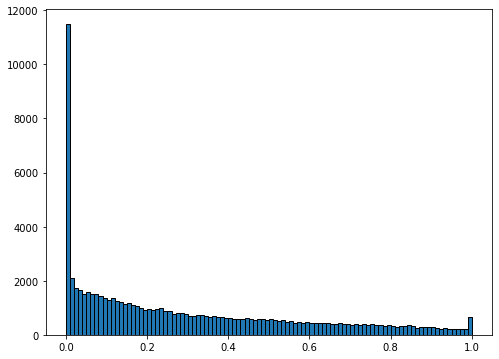

In [23]:
plt.figure(figsize=(8,6))
bins= np.linspace(0,1,101)
ax = plt.gca()
ax.hist(af1, bins=bins,ec="k")
plt.show()

### Test HDF5 Allele Frequencies

In [22]:
ch = 3
with h5py.File(f"./data/hdf5/1240k_v43/ch{ch}.h5", "r") as f: # Load for Sanity Check. See below!
#g = h5py.File("./data/hdf5/HO_v43/ch3.h5", "r")
    print(np.shape(f["calldata/GT"]))
    af1 = f["variants/AF_ALL"][:]

(77601, 14523, 2)
